# Semantic Textual Similarity


**Andrea Cerasani - 10680486** <br> **Fabio Chini - 10669966** <br> **Vincenzo Curreri - 10624628**

# Preliminary analysis

In machine learning, the **train-dev-test** split is a common technique used to evaluate the performance of a model and prevent overfitting. The dataset is divided into three subsets: the **training set**, the **development (or validation) set**, and the **test set**.

The benchmark comprises 8628 sentence pairs. This is the breakdown according to genres and train-dev-test splits:

                train  dev test total 
        -----------------------------
        news     3299  500  500  4299
        caption  2000  625  525  3250
        forum     450  375  254  1079
        -----------------------------
        total    5749 1500 1379  8628

We started by importing all the libraries needed to run the task

In [15]:
import pandas as pd
import numpy as np
import re
from string import punctuation

In [3]:
%pip install matplotlib tqdm unidecode

Note: you may need to restart the kernel to use updated packages.


In [16]:
from matplotlib import pyplot as plt
%matplotlib inline

from tqdm import tqdm
from unidecode import unidecode

In [5]:
%pip install scikit-learn scipy

Note: you may need to restart the kernel to use updated packages.


In [17]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import pearsonr

In [8]:
%pip install -U nltk

Note: you may need to restart the kernel to use updated packages.


In [18]:
import nltk
nltk.download("punkt")
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
%pip install spacy
!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
                                              0.0/12.8 MB ? eta -:--:--
     -                                        0.4/12.8 MB 8.3 MB/s eta 0:00:02
     --                                       0.9/12.8 MB 9.6 MB/s eta 0:00:02
     -----                                    1.7/12.8 MB 10.5 MB/s eta 0:00:02
     -------                                  2.3/12.8 MB 11.1 MB/s eta 0:00:01
     ----------                               3.3/12.8 MB 12.5 MB/s eta 0:00:01
     -------------                            4.5/12.8 MB 13.5 MB/s eta 0:00:01
     ----------------                         5.2/12.8 MB 13.2 MB/s eta 0:00:01
     -----------------                        5.6/12.8 MB 12.4 MB/s eta 0:00:01
     --------------------                     6.4/12.8 MB 12.1 MB/s eta 0:00:01
     ----------------------                   7.3/12.8 MB 12.2 MB/s eta 0:00:01
     --------------------------               8.4/12.8 MB 12.8 M

In [19]:
import spacy
spacy_nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [12]:
%pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [20]:
from gensim.models import Word2Vec
import gensim.downloader as gensim_api

In [ ]:
%pip install "tensorflow>=2.0.0"
%pip install tensorflow_hub

In [21]:
import tensorflow_hub as hub

We start by importing the three datasets: **train**, **test** and **dev** that we will use for our models, assigning each column a suitable title. As you can see, there are **5749**, **1500** and **1379** sentence pairs in the three datasets, respectively

In [22]:
def on_bad_line(values):
    return values[:7]

columns_mapping = {
    0: 'genre',
    1: 'filename',
    2: 'year',
    3: 'index',
    4: 'score',
    5: 'sentence1',
    6: 'sentence2'
}

# quotings 3 = csv.QUOTE_NONE
train_df = pd.read_csv('Dataset/sts-train.csv', sep="\t", on_bad_lines=on_bad_line, engine='python', header=None, encoding='utf-8', quoting=3).rename(columns=columns_mapping)
print(f'Shape of the Train Dataframe: {train_df.shape}')

dev_df = pd.read_csv('Dataset/sts-dev.csv', sep="\t", on_bad_lines=on_bad_line, engine='python', header=None, encoding='utf-8', quoting=3).rename(columns=columns_mapping)
print(f'Shape of the Dev Dataframe: {dev_df.shape}')

test_df = pd.read_csv('Dataset/sts-test.csv', sep="\t", on_bad_lines=on_bad_line, engine='python', header=None, encoding='utf-8', quoting=3).rename(columns=columns_mapping)
print(f'Shape of the Test Dataframe: {test_df.shape}')

train_df.head(3)

Shape of the Train Dataframe: (5749, 7)
Shape of the Dev Dataframe: (1500, 7)
Shape of the Test Dataframe: (1379, 7)


,genre,filename,year,index,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,1,5.0,A plane is taking off.,An air plane is taking off.
1,main-captions,MSRvid,2012test,4,3.8,A man is playing a large flute.,A man is playing a flute.
2,main-captions,MSRvid,2012test,5,3.8,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...


We now begin to **analyze** the train dataset. First we split each pair of sentences into two separate sentences, adding them into a single list, so that we have the **total number** of sentences present in the dataset

In [23]:
sentences1 = train_df["sentence1"]
sentences2 = train_df["sentence2"]
sentences_list = np.unique(train_df['sentence1'].tolist() + train_df['sentence2'].tolist())

print(f"Total number of sentences: {len(sentences_list)}")

Total number of sentences: 10566


We preprocess the list of sentences, removing **special characters**, such as **punctuation** and **accents**, **stopwords** and applying **lemmatization**

In [24]:
def remove_special_chars(text):
    regex = '[' + punctuation + ']'
    return re.sub(regex,'',unidecode(text)).lower()

def remove_stop_words(text):
    stop_words = stopwords.words('english')
    return ' '.join([word for word in text.split() if word not in stop_words])

def lemmatize(text):
    parsed_sentence = spacy_nlp(str(text))
    lemmatized_sentence = ' '.join([word.lemma_ for word in parsed_sentence])
    return lemmatized_sentence


no_punct_sentences_list = np.array([remove_special_chars(string) for string in sentences_list])
clean_sentences_list = np.array([remove_stop_words(string) for string in no_punct_sentences_list])
lemmatized_sentences_list = np.array([remove_stop_words(lemmatize(remove_special_chars(sentence)).lower()) for sentence in clean_sentences_list])


print(f"Original list of sentences:")
for idx, s in enumerate(sentences_list[:5]):
    print(f"{idx+1}) {s}")
print()

print(f"List of preprocessed sentences, without punctuation and stopwords:")
for idx, s in enumerate(clean_sentences_list[:5]):
    print(f"{idx+1}) {s}")
print()

print(f"List of lemmatized sentences:")
for idx, s in enumerate(lemmatized_sentences_list[:5]):
    print(f"{idx+1}) {s}")

Original list of sentences:
1)  - Income, top rate:  percent.
2)  Foxe was mostly frozen.
3)  billion . Everyone in the world at Mexico's current prosperity level.
4)  warmed.C from the year prior.
5) "Americans don't cut and run, we have to see this misadventure through," she said.

List of preprocessed sentences, without punctuation and stopwords:
1) income top rate percent
2) foxe mostly frozen
3) billion everyone world mexicos current prosperity level
4) warmedc year prior
5) americans dont cut run see misadventure said

List of lemmatized sentences:
1) income top rate percent
2) foxe mostly frozen
3) billion everyone world mexicos current prosperity level
4) warmedc year prior
5) americans cut run see misadventure say


In [23]:
array_len = np.vectorize(len)(sentences_list)
mean_len = np.mean(array_len)
print(f"Mean length of sentences in characters: {mean_len:.2f}")

Mean length of sentences in characters: 59.37


Here we find the **maximum** and **minimum** length of sentences, in words, representing it in a graph and showing the **average length** of sentences

Maximum sentence length: 56 words
Minimum sentence length: 2 words
Mean length of sentences in words: 10.17


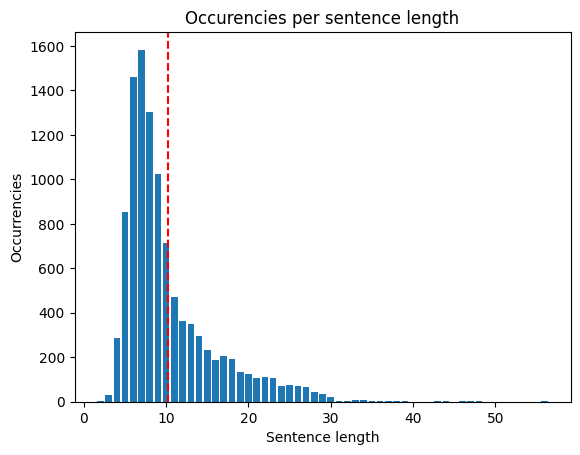

In [12]:
arr_words = np.array([len(s.split()) for s in sentences_list])

print(f"Maximum sentence length: {np.max(arr_words)} words")
print(f"Minimum sentence length: {np.min(arr_words)} words")

mean_sentences_length = np.mean(arr_words)
print(f"Mean length of sentences in words: {mean_sentences_length:.2f}")

unique, counts = np.unique(arr_words, return_counts=True)

plt.bar(unique, counts)

plt.axvline(x=mean_sentences_length, color='r', linestyle='--')

plt.xlabel("Sentence length")
plt.ylabel("Occurrencies")
plt.title("Occurencies per sentence length")


plt.show()

Here we show which **words** are the most **frequent** within the list of sentences

In [60]:
words_with_duplicates = [word for string in no_punct_sentences_list for word in word_tokenize(string)]
words_nostopwords = [w for w in words_with_duplicates if w not in stopwords.words('english')]
counts_nostopwords = nltk.Counter(words_nostopwords)
counts_nostopwords.most_common(20)

[('man', 853),
 ('woman', 547),
 ('two', 458),
 ('said', 455),
 ('dog', 418),
 ('us', 402),
 ('white', 282),
 ('killed', 265),
 ('black', 258),
 ('playing', 254),
 ('percent', 253),
 ('new', 238),
 ('people', 217),
 ('syria', 211),
 ('china', 191),
 ('police', 173),
 ('running', 170),
 ('president', 168),
 ('person', 161),
 ('water', 156)]

Finally, we create the **vocabulary** by performing **tokenization** on all sentences, finding that there are **12243** different words

In [61]:
vocabulary = np.unique(words_nostopwords)
print(len(vocabulary))
print(vocabulary)

12243
['0' '004' '005' ... 'zubaidi' 'zuccarini' 'zuma']


In addition, we analyzed the **distribution** of **similarity scores**, representing it in a graph and showing the **average score**

Mean scores of sentence similarity: 2.70


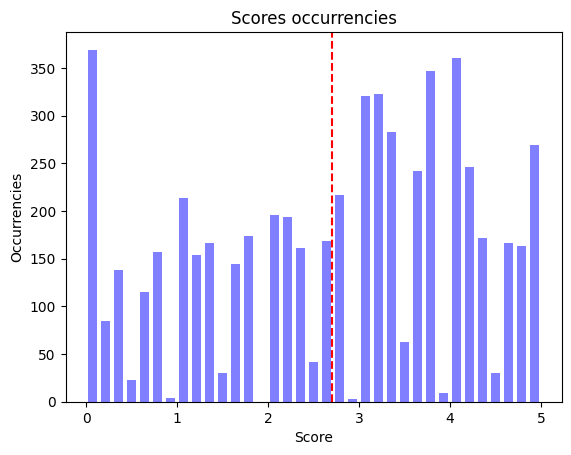

In [62]:
tot_scores = train_df["score"]
scores = np.ravel(tot_scores.values)

mean_scores = np.mean(scores);
print(f"Mean scores of sentence similarity: {mean_scores:.2f}")

plt.hist(scores, bins=35, alpha=0.5, color='blue', rwidth=0.7)

plt.axvline(x=mean_scores, color='r', linestyle='--')

plt.xlabel("Score")
plt.ylabel("Occurrencies")
plt.title("Scores occurrencies")

plt.show()

## Text Clustering

We begin by configuring the **TF-IDF (Term Frequency-Inverse Document Frequency)** method to process a set of sentences to obtain a **numerical representation** that reflects the importance of terms within the sentences.

We apply the TF-IDF method to the **lemmatized sentences** we have collected. We obtain a sparse matrix representing the **frequency** of terms in our corpus of sentences.

Finally, by extracting the vocabulary of unique terms used in the TF-IDF score calculation, we obtain a list of **relevant words** in our corpus.

In [14]:
# creazione della matrice di similarità
tfidf = TfidfVectorizer(max_df=0.8, min_df=0, stop_words='english', strip_accents='ascii')

tfidf_matrix = tfidf.fit_transform(lemmatized_sentences_list)
vocab = tfidf.get_feature_names_out()

print(tfidf_matrix.shape)
print(vocab)

(10566, 9857)
['004' '005' '006' ... 'zubaidi' 'zuccarini' 'zuma']


In [15]:
word = 'dog'
word_id = tfidf.transform([word]).nonzero()[1]
filter = tfidf_matrix.getcol(word_id).nonzero()[0]
print(f'The word {word} is present in {len(filter)} documents. Here\'s the first 5:')
for idx, text in enumerate(no_punct_sentences_list[filter][:5]):
    print(str(idx + 1) + '.' , text)

The word dog is present in 517 documents. Here's the first 5:
1. a baby is playing with a dog
2. a baby plays with a dog and ball
3. a bear is running from two dogs
4. a black and a brown dog running in the grass
5. a black and a yellow dog


We begin by specifying the desired number of **clusters** to group the sentences. Next, we use the **K-means algorithm** to assign each sentence to one of the clusters. The algorithm calculates the distance of the sentences from the **centroids** of the clusters and returns a matrix representing these distances.

Next, we use the nearest cluster index for each sentence to assign a **category** to each sentence. We count how many sentences are assigned to each cluster to get an idea of the number of sentences in each category.

Finally, we create a **graph** to display the number of sentences for each cluster, making it easier to understand the **distribution** of sentences within clusters.

[[1.14046735 1.08209408 1.18268806 ... 1.04827455 1.09872832 1.0003299 ]
 [1.14046735 1.08209408 1.18268806 ... 1.04827455 1.09872832 1.00084739]
 [1.14046735 1.08209408 1.18268806 ... 1.04613295 1.09872832 0.9991366 ]
 ...
 [1.14046735 1.08209408 1.18268806 ... 1.04770756 1.0982164  0.99900267]
 [1.14046735 1.08128212 1.18268806 ... 1.04827455 1.09768281 0.99755638]
 [1.14046735 1.07957184 1.17825067 ... 1.04741062 1.09872832 0.99843948]]
[26 29 29 ...  3  3 29]


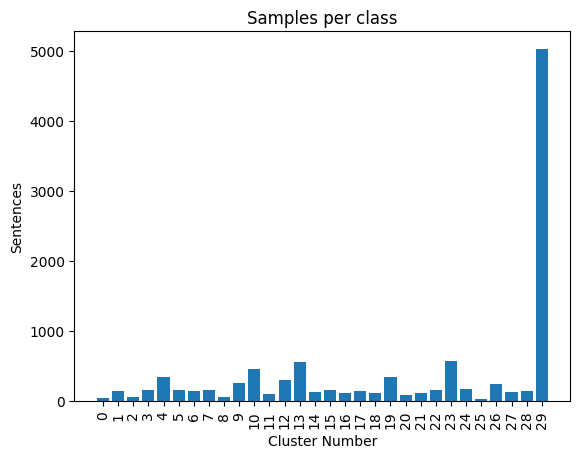

In [16]:
k = 30
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
cluster_matrix = kmeans.fit_transform(tfidf_matrix)
print(cluster_matrix)
clusters = np.argmin(cluster_matrix, axis=-1)
print(clusters)

uniques, counts = np.unique(clusters, return_counts=True)
plt.bar(uniques, counts)
plt.xlabel('Cluster Number')
plt.ylabel('Sentences')
plt.xticks(uniques, rotation=90)
plt.title('Samples per class')
plt.show()

As we can see there is a very large cluster that might correspond to more common terms across the corpus. The other clusters though look well distributed

In [17]:
print("Top terms per cluster:")

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]    
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:5]]}")

Top terms per cluster:
Cluster 0:	['sheep', 'stand', 'black', 'field', 'hill']
Cluster 1:	['sit', 'table', 'people', 'man', 'woman']
Cluster 2:	['dance', 'woman', 'man', 'group', 'rain']
Cluster 3:	['small', 'international', 'end', 'myanmar', 'state']
Cluster 4:	['dog', 'run', 'snow', 'grass', 'brown']
Cluster 5:	['stock', 'close', 'high', 'low', 'open']
Cluster 6:	['korea', 'south', 'north', 'korean', 'nuclear']
Cluster 7:	['attack', 'kill', 'iraq', 'suicide', 'bomb']
Cluster 8:	['chemical', 'weapon', 'syria', 'use', 'destroy']
Cluster 9:	['play', 'man', 'guitar', 'boy', 'piano']
Cluster 10:	['woman', 'slice', 'cut', 'man', 'meat']
Cluster 11:	['train', 'track', 'station', 'crash', 'dead']
Cluster 12:	['kill', 'afghanistan', 'soldier', 'bomb', 'suicide']
Cluster 13:	['say', 'official', 'police', 'spokesman', 'mr']
Cluster 14:	['pakistan', 'kill', 'drone', 'strike', 'taliban']
Cluster 15:	['person', 'slice', 'cut', 'piece', 'onion']
Cluster 16:	['cat', 'white', 'look', 'black', 'play']

We now show the sentences belonging to **Cluster 4** (showing them from the list of sentences not preprocessed to improve readability). They appear to actually have arguments in common!

In [18]:
print(np.array(sentences_list)[kmeans.labels_ == 4][:10])

['A bear is running from two dogs.'
 'A black and a brown dog running in the grass.'
 'A black and a yellow dog'
 'A black and brown dog runs through the woods.'
 'A black and white dog is carrying a stick in its mouth.'
 'A black and white dog is running in the grass.'
 'A black and white dog is running on the beach.'
 'A black and white dog is running through a cow field.'
 'A black and white dog is running through grass.'
 'A black and white dog is running through the field.']


For each cluster, we are trying to figure out which terms are **most relevant** to that cluster and which sentences are most similar to its **centroid**.

We print the most important terms in the cluster and the top **10 sentences** most similar to its centroid. This helps us better understand the characteristics of the cluster and the representative sentences in it.

In [56]:
top_sentence_per_cluster = []
# print the top 10 words in each cluster
for i in range(k):
    centroid = kmeans.cluster_centers_[i]    
    sorted_terms = centroid.argsort()[::-1]
    print(f"\nCluster {i} - {[vocab[j] for j in sorted_terms[:5]]}:")

    i_labelled_sentence_vectors = tfidf_matrix[kmeans.labels_ == i]
    i_labelled_sentences = np.array(lemmatized_sentences_list)[kmeans.labels_ == i]
    # sorting the terms to most similar to the centroid
    sorted_sentences = i_labelled_sentences[np.argsort(cosine_similarity(i_labelled_sentence_vectors, [centroid]).flatten())[::-1]]

    top_sentence_per_cluster.append(sorted_sentences[0])
    
    for idx, sentence in enumerate(sorted_sentences[:10]):
        print(str(idx + 1) + ") ",sentence)


Cluster 0 - ['sheep', 'stand', 'black', 'field', 'hill']:
1)  black white sheep walk next white sheep
2)  sheep stand tree
3)  group sheep field
4)  large dog stand next sheep field
5)  large sheep stand hill
6)  ten sheep look camera
7)  many sheep stand green hill
8)  group sheep hill
9)  white sheep stand green hill
10)  sheep stand near child

Cluster 1 - ['sit', 'table', 'people', 'man', 'woman']:
1)  four people sit table
2)  two people sit table restaurant
3)  group people sit around table food
4)  three man sit table drink
5)  group people sit restaurant table
6)  group people sit table restaurant
7)  man sit rock
8)  group people sit table drink
9)  three man suit sit table
10)  group elderly people sit around table

Cluster 2 - ['dance', 'woman', 'man', 'group', 'rain']:
1)  man dance
2)  man dance
3)  two man dance
4)  man dance
5)  three woman dance
6)  woman dance
7)  woman dance fire
8)  two woman dance
9)  man woman dance
10)  group man dance

Cluster 3 - ['small', 'int

We use a technique called **t-SNE** to reduce the complexity of the data and project it into a **two-dimensional graph**. Clearly **Cluster 29** is the largest, as can be seen from the graph.

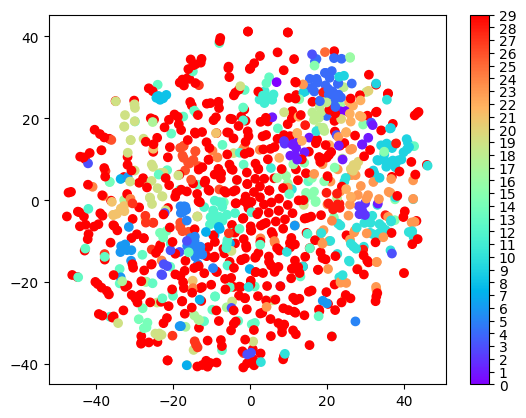

In [57]:
# visualize the clusters using manifold learning
from sklearn.manifold import TSNE
from matplotlib import ticker

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(tfidf_matrix.toarray()[::10])
# plot the clusters printng the color scale
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters[::10], cmap='rainbow')
# (generate plot here)
cb = plt.colorbar()
tick_locator = ticker.MaxNLocator(nbins=30)
cb.locator = tick_locator
cb.update_ticks()
plt.show()

We now select **few clusters** to show, which seem to have common topics. As you can see, **Clusters 0** and **Cluster 4** are close to each other because they have **"animals in nature"** as a common topic, but far away to **Clusters 15** and **Cluster 8** which have a different main topic, concerning **"people cutting something"** and **"war and chemical weapons"** respectively. **Cluster 18** has elements close to **Clusters 0** and **Cluster 4** because it has common elements such as **"dog"** and **"snow"**, although the main topic of **Cluster 18** seems to be **"people walking"**

In [58]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=50, random_state=42)
pca_embeddings = pca_model.fit_transform(tfidf_matrix.toarray())

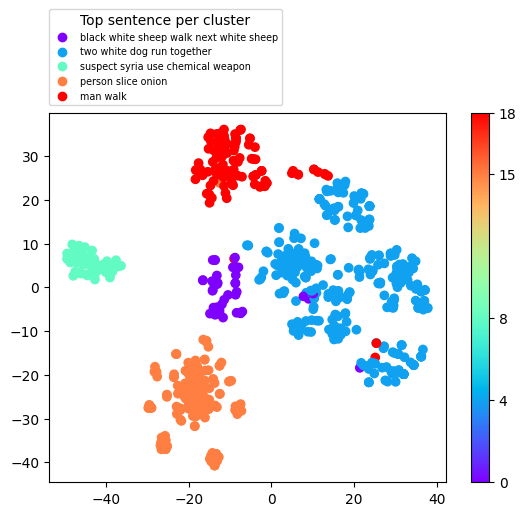

In [60]:
from sklearn.manifold import TSNE

selected_clusters = [0, 4, 8, 15, 18]
cluster_mask = np.isin(clusters, selected_clusters)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(pca_embeddings[cluster_mask])
# plot the clusters printng the color scale
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters[cluster_mask], cmap='rainbow')
handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, np.array(top_sentence_per_cluster)[selected_clusters], loc='lower left', bbox_to_anchor=(0, 1.02, 1, 0.2), ncol=1, borderaxespad=0., fontsize='x-small', title='Top sentence per cluster')
# (generate plot here)
cb = plt.colorbar()
cb.set_ticks(selected_clusters)
plt.show()

Now we use **Word2Vec** to generate meaningful word **embeddings** from the tokenized sentences. Then, we apply K-means clustering to group the word vectors into **clusters based** on their similarity. Finally, we plot the distribution of sentences assigned to each cluster.

In [70]:
tokenized_corpus = [word_tokenize(w) for w in lemmatized_sentences_list]
word2vec_cluster_model = Word2Vec(tokenized_corpus, vector_size=100, min_count=4, window=5, negative=10, workers=4, sg=0, cbow_mean=1, epochs=150, seed=42)
print("vocabular size:", len(word2vec_cluster_model.wv.key_to_index))

vocabular size: 3121


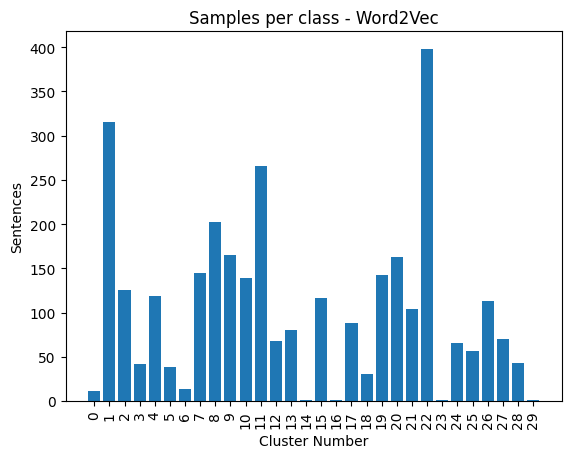

In [71]:
k = 30
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
cluster_matrix = kmeans.fit_transform(word2vec_cluster_model.wv.vectors)
clusters = np.argmin(cluster_matrix, axis=-1)

uniques, counts = np.unique(clusters, return_counts=True)
plt.bar(uniques, counts)
plt.xlabel('Cluster Number')
plt.ylabel('Words')
plt.xticks(uniques, rotation=90)
plt.title('Samples per class - Word2Vec')
plt.show()

In [72]:
print("Top terms per cluster:")

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]    
    i_labelled_terms = np.array(word2vec_cluster_model.wv.index_to_key)[kmeans.labels_ == i]
    # sorting the terms to most similar to the centroid
    sorted_terms = i_labelled_terms[np.argsort(cosine_similarity(word2vec_cluster_model.wv[i_labelled_terms], [centroid]).flatten())[::-1]]
    print(f"Cluster {i}:\t{[w for w in sorted_terms[:10]]}")

Top terms per cluster:
Cluster 0:	['woman', 'man', 'boy', 'girl', 'child', 'person', 'shirt', 'kid', 'wear', 'table']
Cluster 1:	['observe', 'erdogan', 'zimbabwe', 'annan', 'winner', 'suu', 'unite', 'hollande', 'leadership', 'orders']
Cluster 2:	['sharp', 'philips', 'sony', 'dell', 'corp', 'product', 'pylon', 'application', 'software', 'hewlettpackard']
Cluster 3:	['cent', 'percent', 'share', 'nasdaq', 'index', 'stock', 'ixic', 'spx', 'august', 'average']
Cluster 4:	['lick', 'sit', 'finger', 'singe', 'flute', 'piano', 'stand', 'keyboard', 'hat', 'sing']
Cluster 5:	['russian', 'mexican', 'israeli', 'chinese', 'iranian', 'syrian', 'egypt', 'colombian', 'ukraine', 'syria']
Cluster 6:	['minister', 'prime', 'cabinet', 'crisis', 'assembly', 'party', 'opposition', 'foreign', 'begin', 'eu']
Cluster 7:	['rapper', 'criminal', 'extortion', 'killer', 'guilty', 'saddam', 'trayvon', 'assault', 'strausskahn', 'allegation']
Cluster 8:	['museum', 'violent', 'shanghai', 'midwest', 'nw', 'gangrape', 'sho

## Topic Models

We use **CountVectorizer** to convert the lemmatized sentences into a **matrix** of word counts. Then, we apply **Latent Dirichlet Allocation (LDA)** to identify the main topics present in the text data.

In [73]:
count_vectorizer = CountVectorizer(stop_words='english',min_df=5,max_df=.5)
count_matrix = count_vectorizer.fit_transform(lemmatized_sentences_list)
count_vocab = count_vectorizer.get_feature_names_out()

In [74]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=30, verbose=0, learning_method='online', max_iter=30)
lda.fit(count_matrix)

LatentDirichletAllocation(learning_method='online', max_iter=30,
                          n_components=30)

We print the top terms for each topic to gain insights into the main themes captured by the LDA model.

In [75]:
for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    concatenated_terms = '[' + ', '.join(count_vocab[i] for i in sorted_terms[:10]) + ']'
    print (f'Topic {i + 1}:\t', concatenated_terms)

Topic 1:	 [hit, chemical, 10, oil, low, country, month, second, add, quake]
Topic 2:	 [nuclear, iran, weapon, north, drug, korea, united, states, indian, return]
Topic 3:	 [water, person, vote, release, tuesday, defense, know, accord, control, yesterday]
Topic 4:	 [ride, bird, tree, program, bowl, demand, university, hill, peaceful, town]
Topic 5:	 [dog, white, black, sit, brown, use, cat, horse, blue, small]
Topic 6:	 [percent, state, report, close, share, point, cent, index, nasdaq, wednesday]
Topic 7:	 [russia, big, trial, computer, war, comment, romney, watch, decline, march]
Topic 8:	 [force, cut, slice, right, service, missile, want, action, test, onion]
Topic 9:	 [say, security, building, europe, work, collapse, mr, rock, miss, offer]
Topic 10:	 [girl, president, say, deal, minister, palestinian, chief, news, issue, mandela]
Topic 11:	 [china, stand, charge, road, murder, field, eu, major, place, accident]
Topic 12:	 [track, area, race, piece, pick, floor, 2013, department, couc

We generate a **visual representatio**n of the most important terms and their weights for a set of predefined topics obtained from LDA. We show **Topic 2**, **Topic 10** and **Topic 26** as examples, noting that the **weights** may be unevenly distributed.

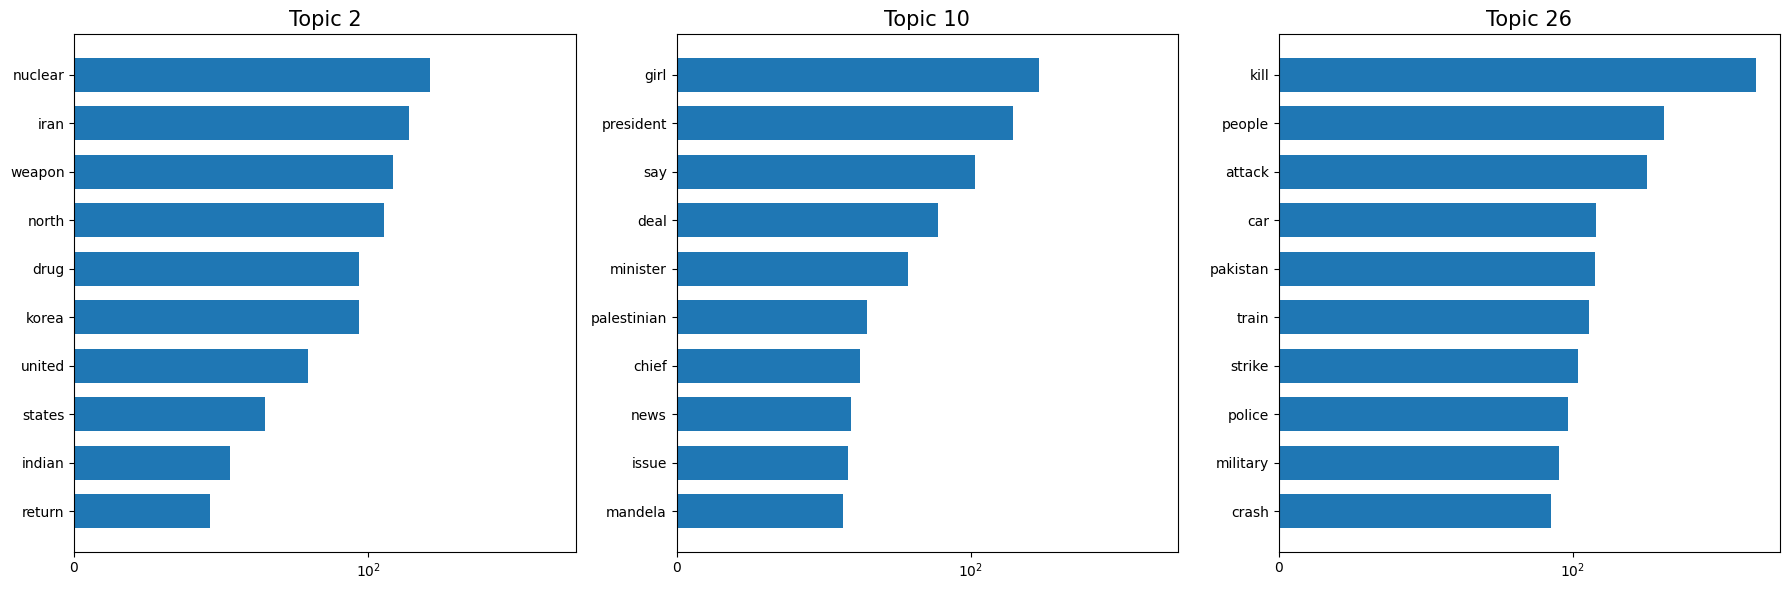

In [76]:
num_words = 10
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
topic_indices = [1, 9, 25]

for i, topic_idx in enumerate(topic_indices):
    topic = lda.components_[topic_idx]
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [count_vocab[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[i]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx + 1}', fontdict={'fontsize': 15})
    ax.invert_yaxis()
    ax.set_xscale('symlog', linthresh=100)

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.20, hspace=0.3)
plt.tight_layout()
plt.show()


# Training models
We now turn our attention to the task of **sentence similarity**. In this context, we will utilize familiar models like **TF-IDF** and **Word2Vec**, which we have encountered earlier. Additionally, we will explore other approaches, such as Transformers.

## Bag of Words

Having just completed the training of a **TF-IDF** model for **clustering** purposes, we can further leverage this model to compute the similarity between sentences. With a **bag-of-words** approach, we can represent each sentence as a vector by considering the **frequency of words** in the sentence within the entire corpus. By comparing these vector representations, we can quantify the **similarity** between **sentences** based on their shared words and their respective frequencies.

In [40]:
def evaluate_pearson_correlation(model: TfidfVectorizer, dataset: pd.DataFrame):
    predicted_scores = []
    for s1,s2 in zip(dataset["sentence1"], dataset["sentence2"]):
        vectorized_sentences = model.transform([s1, s2])
        predicted_scores.append(cosine_similarity(vectorized_sentences)[0][1])
    
    return pearsonr(predicted_scores, dataset["score"].values)

In [229]:
untouched_dataset = pd.DataFrame({
    'sentence1': train_df['sentence1'],
    'sentence2': train_df['sentence2'],
    'score': train_df['score'] / 5
})

untouched_test_dataset = pd.DataFrame({
    'sentence1': test_df['sentence1'],
    'sentence2': test_df['sentence2'],
    'score': test_df['score'] / 5
})

untouched_dev_dataset = pd.DataFrame({
    'sentence1': dev_df['sentence1'],
    'sentence2': dev_df['sentence2'],
    'score': dev_df['score'] / 5
})

In [18]:
clean_dataset = pd.DataFrame({
    'sentence1': train_df['sentence1'].map(remove_special_chars).map(remove_stop_words),
    'sentence2': train_df['sentence2'].map(remove_special_chars).map(remove_stop_words),
    'score': train_df['score'] / 5
})

clean_test_dataset = pd.DataFrame({
    'sentence1': test_df['sentence1'].map(remove_special_chars).map(remove_stop_words),
    'sentence2': test_df['sentence2'].map(remove_special_chars).map(remove_stop_words),
    'score': test_df['score'] / 5
})

clean_dev_dataset = pd.DataFrame({
    'sentence1': dev_df['sentence1'].map(remove_special_chars).map(remove_stop_words),
    'sentence2': dev_df['sentence2'].map(remove_special_chars).map(remove_stop_words),
    'score': dev_df['score'] / 5
})

In [19]:
lemmatized_dataset = pd.DataFrame({
    'sentence1': clean_dataset['sentence1'].map(lemmatize),
    'sentence2': clean_dataset['sentence2'].map(lemmatize),
    'score': clean_dataset['score']
})

lemmatized_test_dataset = pd.DataFrame({
    'sentence1': clean_test_dataset['sentence1'].map(lemmatize),
    'sentence2': clean_test_dataset['sentence2'].map(lemmatize),
    'score': clean_test_dataset['score']
})

lemmatized_dev_dataset = pd.DataFrame({
    'sentence1': clean_dev_dataset['sentence1'].map(lemmatize),
    'sentence2': clean_dev_dataset['sentence2'].map(lemmatize),
    'score': clean_dev_dataset['score']
})

We train a Tf-idf model using non-preprocessed sentence list

In [243]:
tfidf_vectorizer_simple = TfidfVectorizer(analyzer='word', ngram_range=(1,1))
tfidf_vectorizer_simple.fit(sentences_list)

print("Pearson correlation:", evaluate_pearson_correlation(tfidf_vectorizer_simple, untouched_test_dataset).correlation)

Pearson correlation: 0.6587586833220163


We try to improve it using the list of lemmatized sentences

In [244]:
tfidf_vectorizer_lemmatized = TfidfVectorizer(analyzer='word', ngram_range=(1,1), lowercase=True)
tfidf_vectorizer_lemmatized.fit(lemmatized_sentences_list)

print("Pearson correlation:", evaluate_pearson_correlation(tfidf_vectorizer_lemmatized, lemmatized_test_dataset).correlation)

Pearson correlation: 0.6767943027336835


Finally we try to improve it using character n-gram

In [245]:
trigrams_tfidf_vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5))
trigrams_tfidf_vectorizer.fit(sentences_list)

print("Pearson correlation:", evaluate_pearson_correlation(trigrams_tfidf_vectorizer, untouched_test_dataset).correlation)


Pearson correlation: 0.7140034205412866


Here we are printing the **most similar** sentences to a specific sentence based on **cosine similarity** using the **TF-IDF matrix**. This allows us to see both the original sentence and the **degree of similarity** calculated for every similar sentence.

In [250]:
tfidf_trigrams_matrix = trigrams_tfidf_vectorizer.transform(sentences_list)
tfidf_similarity = cosine_similarity(tfidf_trigrams_matrix)
tfidf_sentence_idx = 10
print(sentences_list[tfidf_sentence_idx])
for i, col_idx in enumerate(tfidf_similarity[tfidf_sentence_idx].argsort()[::-1][1:6]):
    print(str(i+1) + ")",f"{tfidf_similarity[tfidf_sentence_idx][col_idx]:.2f} ", f"-> {sentences_list[col_idx]}")

"Biotech products, if anything, may be safer than conventional products because of all the testing," said Robert Fraley, Monsanto's executive vice president.
1) 0.71  -> "Biotech products, if anything, may be safer than conventional products because of all the testing," Fraley said, adding that 18 countries have adopted biotechnology.
2) 0.23  -> As executive vice president of new ventures, Elias will report to Joe Tucci, EMC's president and chief executive.
3) 0.21  -> Products featuring Vanderpool will be released within five years, he said.
4) 0.19  -> The onus is on the manufacturer of a product to convince consumers it is safe.
5) 0.17  -> The third appointment was to a new job, executive vice president and chief staff officer.


In [94]:
# Saving the lemmatized sentences to a txt file
with open('Dataset/lemmatized_sentences.txt', 'w') as f:
    for item in lemmatized_sentences_list:
        f.write("%s\n" % item)

## Word2Vec

In [95]:
stop_words = stopwords.words('english')

def preprocess_and_tokenize(sentence):
    temp = ' '.join([word.lemma_.lower() for word in spacy_nlp(str(sentence)) if word.lemma_.lower() not in stop_words])
    temp = re.sub(f'[{punctuation}]', '', unidecode(temp))
    #temp = re.sub(r'\d+(\.\d+)?', 'number', temp)
    return word_tokenize(temp)

tokenized_sentences = [preprocess_and_tokenize(w) for w in sentences_list]

In [96]:
model = Word2Vec(tokenized_sentences, vector_size=50, min_count=4, window=5, negative=10, workers=4, sg=0, cbow_mean=1, epochs=150, seed=42)
print("vocabular size:", len(model.wv.key_to_index))

#print most similar words to
for item in ['car', 'boy', 'man', 'girl', 'woman', 'obama', 'florida', 'cat', 'dog', 'blue', 'kill', 'bomb', 'piano', 'pizza', 'italy']:
    print(item, '-->', [w for w, s in model.wv.most_similar(item)])

vocabular size: 3159
car --> ['truck', 'motorcycle', 'bicycle', 'explode', 'silver', 'fence', 'ranger', 'lot', 'vehicle', 'sidewalk']
boy --> ['kid', 'girl', 'man', 'woman', 'child', 'shirt', 'person', 'dog', 'band', 'couple']
man --> ['woman', 'person', 'girl', 'boy', 'guy', 'pink', 'dog', 'animal', 'child', 'surfer']
girl --> ['woman', 'man', 'boy', 'couple', 'child', 'blue', 'kid', 'jacket', 'suit', 'hat']
woman --> ['girl', 'man', 'boy', 'couple', 'person', 'suit', 'child', 'lady', 'blue', 'baby']
obama --> ['cameron', 'defend', 'decision', 'rebuild', 'haiti', 'want', 'ann', 'turkey', 'renew', 'negotiate']
florida --> ['voting', 'graham', 'haiti', 'ann', 'bob', 'speaker', 'tornado', 'holiday', 'convention', 'outfielder']
cat --> ['blanket', 'kitten', 'leather', 'dog', 'couch', 'animal', 'kitchen', 'grey', 'laptop', 'eagle']
dog --> ['puppy', 'animal', 'ball', 'mouth', 'tan', 'black', 'kitten', 'snow', 'cow', 'sand']
blue --> ['pink', 'yellow', 'orange', 'girl', 'green', 'purple', '

In [97]:
def vectorize(sentences, vocab, vectorizer, vector_size=50):
    # create a matrix with rows equal to the number of tweets and columns equal to the embedding size
    vectors = np.zeros((len(sentences), vector_size))

    # for each sentence in the dataset compute the embedding 
    for i, sentence in enumerate(sentences):
        tokens = preprocess_and_tokenize(sentence)
        embeddings = [vectorizer(token) for token in tokens if token in vocab] # embedding per ogni token
        if (len(embeddings) > 0): # unisce tutti gli embedding in base a useSum
            vectors[i] = np.mean(embeddings, axis=0)
    return vectors

In [ ]:
# modified version of vectorize that weightes the embeddings by the tf-idf score of the word
def vectorize_tfidf(sentences, vocab, vectorizer, tfidf_matrix, useSum=False, vector_size=100, tokenizer=lambda x: x.split()):
    # create a matrix with rows equal to the number of tweets and columns equal to the embedding size
    vectors = np.zeros((len(sentences), vector_size))

    # for each sentence in the dataset compute the embedding 
    for i, sentence in enumerate(sentences):
        tokens = tokenizer(sentence)
        embeddings = [vectorizer(token) * tfidf_matrix[i, vocab.index(token)] for token in tokens if token in vocab] # embedding per ogni token
        if (len(embeddings) > 0): # unisce tutti gli embedding in base a useSum
            if (useSum): 
                vectors[i] = sum(embeddings)
            else:
                vectors[i] = np.mean(embeddings, axis=0)
    return vectors

In [ ]:
def predict_word2vec_similarity(model, dataset):
    predicted_scores = []
    for idx, row in dataset.iterrows():
        sentences = [row['sentence1'], row['sentence2']]
        vectors = vectorize(sentences, model.wv, model.wv.get_vector)
        similarity = cosine_similarity(vectors)[0][1]
        similarity = np.clip(similarity, -1, 1)
        predicted_scores.append(similarity)

mse = mean_squared_error(lemmatized_dataset["score"].values, predict_word2vec_similarity(model, lemmatized_dataset))
print("MSE:", mse)

In [19]:
temp = []
for a, b in zip(train_df["sentence1"], train_df["sentence2"]):
    temp.append(np.ravel(vectorize([a, b], model.wv.key_to_index, model.wv.get_vector)))
    temp.append(np.ravel(vectorize([b, a], model.wv.key_to_index, model.wv.get_vector)))
X_train = np.array(temp)
y_train = np.repeat(train_df["score"].values / 5, 2)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

temp = []
for a, b in zip(test_df["sentence1"], test_df["sentence2"]):
    temp.append(np.ravel(vectorize([a, b], model.wv.key_to_index, model.wv.get_vector)))
    temp.append(np.ravel(vectorize([b, a], model.wv.key_to_index, model.wv.get_vector)))
X_test = np.array(temp)
y_test = np.repeat(test_df["score"].values / 5, 2)

print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (11498, 100)
y_train shape: (11498,)
X_test shape: (2758, 100)
y_test shape: (2758,)


In [99]:
regressor = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
print('RandomForestRegressor (on our Word2Vec model):')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'Pearson: {pearsonr(y_test, y_pred)[0]}')

RandomForestRegressor (on our Word2Vec model):
MSE: 0.07399494858255294
Pearson: 0.48183670698990505


In [100]:
model_wiki = gensim_api.load("glove-wiki-gigaword-50")

#print most similar words to
for item in ['car', 'boy', 'man', 'girl', 'woman', 'obama', 'florida', 'cat', 'dog', 'blue', 'kill', 'bomb', 'piano', 'pizza', 'italy']:
    print(item, '-->', [w for w, s in model_wiki.most_similar(item)])

car --> ['truck', 'cars', 'vehicle', 'driver', 'driving', 'bus', 'vehicles', 'parked', 'motorcycle', 'taxi']
boy --> ['girl', 'woman', 'man', 'kid', 'mother', 'teenage', 'baby', 'dad', 'her', 'old']
man --> ['woman', 'boy', 'another', 'old', 'one', 'who', 'him', 'turned', 'whose', 'himself']
girl --> ['boy', 'woman', 'mother', 'girls', 'girlfriend', 'teenage', 'her', 'teen', 'baby', 'man']
woman --> ['girl', 'man', 'mother', 'her', 'boy', 'she', 'herself', 'child', 'wife', 'old']
obama --> ['barack', 'bush', 'clinton', 'mccain', 'dole', 'gore', 'hillary', 'rodham', 'kerry', 'biden']
florida --> ['arizona', 'texas', 'colorado', 'miami', 'california', 'kansas', 'carolina', 'minnesota', 'louisiana', 'sacramento']
cat --> ['dog', 'rabbit', 'monkey', 'rat', 'cats', 'snake', 'dogs', 'pet', 'mouse', 'bite']
dog --> ['cat', 'dogs', 'horse', 'puppy', 'pet', 'rabbit', 'pig', 'snake', 'baby', 'bite']
blue --> ['red', 'black', 'pink', 'green', 'yellow', 'purple', 'white', 'orange', 'bright', 'colo

In [101]:
temp = []
for a, b in zip(train_df["sentence1"], train_df["sentence2"]):
    temp.append(np.ravel(vectorize([a, b], model_wiki.key_to_index, model_wiki.get_vector)))
    temp.append(np.ravel(vectorize([b, a], model_wiki.key_to_index, model_wiki.get_vector)))
X_train = np.array(temp)
y_train = np.repeat(train_df["score"].values / 5, 2)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

temp = []
for a, b in zip(test_df["sentence1"], test_df["sentence2"]):
    temp.append(np.ravel(vectorize([a, b], model_wiki.key_to_index, model_wiki.get_vector)))
    temp.append(np.ravel(vectorize([b, a], model_wiki.key_to_index, model_wiki.get_vector)))
X_test = np.array(temp)
y_test = np.repeat(test_df["score"].values / 5, 2)

print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (11498, 100)
y_train shape: (11498,)
X_test shape: (2758, 100)
y_test shape: (2758,)


In [102]:
regressor = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
print('RandomForestRegressor (on pretrained Glove model):')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'Pearson: {pearsonr(y_test, y_pred)[0]}')

RandomForestRegressor (on pretrained Glove model):
MSE: 0.07175080290579616
Pearson: 0.5247575093596499


## SubWord embedding: FastText

In [103]:
import fasttext

In [104]:
dataset_filename = 'Dataset/parsed_sentences.txt'

with open(dataset_filename, 'w') as f:
    for item in tokenized_sentences:
        f.write("%s\n" % ' '.join(item))

In [105]:
ft_model = fasttext.train_unsupervised(dataset_filename, model='cbow', dim=50, minn=3, maxn=5, ws=5, epoch=300)

for item in ['car', 'boy', 'man', 'girl', 'woman', 'obama', 'florida', 'cat', 'dog', 'blue', 'kill', 'bomb', 'piano', 'pizza', 'italy']:
    print(item, '-->', [s for w, s in ft_model.get_nearest_neighbors(item)])

car --> ['bicycle', 'bomb', 'track', 'trail', 'kill', 'train', 'station', 'tree', 'rail', 'least']
boy --> ['play', 'young', 'man', 'walk', 'graze', 'girl', 'sidewalk', 'kid', 'two', 'sand']
man --> ['woman', '</s>', 'boy', 'sidewalk', 'girl', 'onto', 'two', 'suit', 'shirt', 'bamboo']
girl --> ['young', 'wear', 'helmet', 'little', '</s>', 'blonde', 'woman', 'man', 'pink', 'two']
woman --> ['man', '</s>', 'girl', 'two', 'bamboo', 'sidewalk', 'smile', 'pizza', 'fry', 'guy']
obama --> ['mitt', 'romney', 'gay', 'vote', 'lift', 'mandela', 'un', 'call', 'syria', 'calm']
florida --> ['enforcement', 'california', 'john', 'maryland', 'jordanian', 'fla', 'student', 'sixth', 'speaker', 'pm']
cat --> ['blanket', 'white', 'kitten', 'laptop', 'window', 'grey', 'desk', 'black', 'lay', 'kitchen']
dog --> ['brown', 'white', 'run', 'black', 'mouth', 'grass', 'snow', 'walk', 'duck', 'water']
blue --> ['background', 'front', 'yellow', 'small', 'red', 'orange', 'dress', 'blonde', 'white', 'bird']
kill --> 

In [251]:
temp = []
for a, b in zip(train_df["sentence1"], train_df["sentence2"]):
    temp.append(np.ravel(vectorize([a, b], ft_model.words, ft_model.get_word_vector)))
    temp.append(np.ravel(vectorize([b, a], ft_model.words, ft_model.get_word_vector)))
X_train = np.array(temp)
y_train = np.repeat(train_df["score"].values / 5, 2)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

temp = []
for a, b in zip(test_df["sentence1"], test_df["sentence2"]):
    temp.append(np.ravel(vectorize([a, b], ft_model.words, ft_model.get_word_vector)))
    temp.append(np.ravel(vectorize([b, a], ft_model.words, ft_model.get_word_vector)))
X_test = np.array(temp)
y_test = np.repeat(test_df["score"].values / 5, 2)

print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (11498, 100)
y_train shape: (11498,)
X_test shape: (2758, 100)
y_test shape: (2758,)


In [ ]:
regressor = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
print('RandomForestRegressor (on our FastText model):')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'Pearson: {pearsonr(y_test, y_pred)[0]}')

RandomForestRegressor (on our FastText model):
MSE: 0.0738387157872733
Pearson: 0.48298803757523495


## Universal Sentence Encoder

The **Universal Sentence Encoder** is a powerful tool that converts text into high-dimensional vectors, enabling **semantic similarity** analysis. It undergoes training using different data sources and tasks, allowing it to adapt dynamically to various natural language understanding needs. When given variable length English text as input, it produces a **512-dimensional vector** as output. This encoder model is trained with a **Deep Averaging Network (DAN)**.

In the **DAN** approach, **word** and **bi-gram** embeddings within a sentence are **averaged** together. These averaged embeddings then pass through a 4-layer feed-forward deep DNN, resulting in a **512-dimensional sentence embedding** as the final output. The word and bi-gram embeddings are learned during the training process.

![Deep Averaging Network embedding](https://amitness.com/images/use-deep-averaging-network-variant.png)

In [10]:
embed = hub.load("universal-sentence-encoder_4")

2023-05-28 17:13:47.823529: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34133760 exceeds 10% of free system memory.
2023-05-28 17:13:47.878600: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34133760 exceeds 10% of free system memory.
2023-05-28 17:13:47.931156: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34133760 exceeds 10% of free system memory.
2023-05-28 17:13:47.981855: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34133760 exceeds 10% of free system memory.
2023-05-28 17:13:48.031727: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34133760 exceeds 10% of free system memory.


In [11]:
y_pred = []
for s1, s2 in zip(test_df['sentence1'], test_df['sentence2']):
    embeddings = embed([s1, s2])
    simil = cosine_similarity(embeddings, embeddings)[0][1]
    y_pred.append(simil)

print(f'Pearson corr: {pearsonr(y_pred, test_df["score"])[0]}')

2023-05-28 17:13:54.699210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]


Pearson corr: 0.7872796725912385


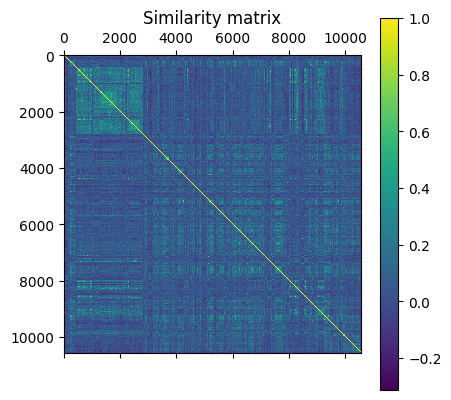

In [12]:
some_embeddings = embed(sentences_list)
similarity_matrix = cosine_similarity(some_embeddings)
plt.matshow(similarity_matrix)
plt.title('Similarity matrix')
plt.colorbar()

In the matrix, each row and column represents a sentence in the test set, while the cells within the matrix indicate the similarity between sentences. 

An interesting observation is the presence of a cluster of sentences in the top left portion of the matrix that exhibit a high degree of similarity among themselves.

Furthermore, there is a distinct yellow diagonal, which signifies the self-similarity of each sentence. 

Text(0.5, 1.0, 'Embeddings matrix')

<Figure size 1000x800 with 0 Axes>

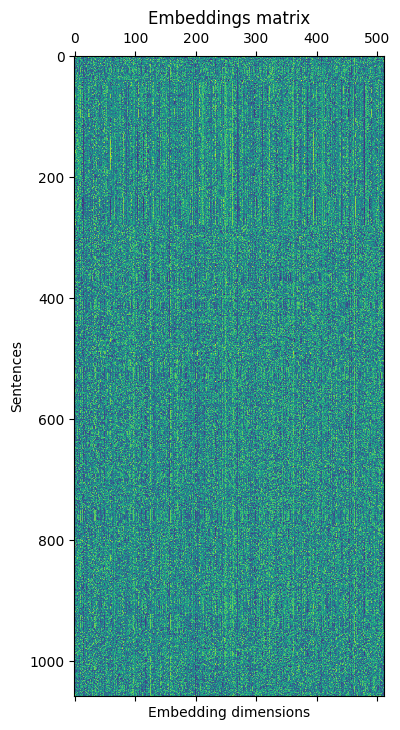

In [13]:
fig = plt.figure(figsize=(10,8))
plt.matshow(some_embeddings[::10], aspect='auto')
plt.xlabel('Embedding dimensions')
plt.ylabel('Sentences')
plt.title('Embeddings matrix')

This matrix illustrates the dimensions of the embeddings for each sentence. By examining the graphic, we can once again identify a group of sentences that share similarity. This is evident in the upper part of the matrix, where we observe a consistent and similar pattern of colors across the rows.

# Transformers
![Comparison bi-encoder and cross-encoder](https://raw.githubusercontent.com/UKPLab/sentence-transformers/master/docs/img/Bi_vs_Cross-Encoder.png)

In [ ]:
from torch.utils.data import DataLoader
import math
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, util, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import logging
from datetime import datetime

In [ ]:
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator

## Bi-Encoders
Bi-Encoders produce for a given sentence a sentence embedding. We pass to a BERT independently the sentences A and B, which result in the sentence embeddings u and v. These sentence embedding can then be compared using cosine similarity

In this example we fine tune a pre-trained SentenceTransformer model on the STS benchmark dataset.

Reimers, N., & Gurevych, I. (2019). Sentence-BERT: Sentence embeddings using Siamese BERT-networks. In arXiv [cs.CL]. http://arxiv.org/abs/1908.10084

### Fine Tuning a pre-trained model
In this example we fine tune a pre-trained model. The model was first trained on NLI data, we now finetune it on the STS benchmark dataset.

In [ ]:
#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

# Read the dataset
model_name = 'nli-distilroberta-base-v2'
train_batch_size = 16
num_epochs = 10
model_save_path = 'output/bi_encoder_fine_tuning-'+model_name+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Load a pre-trained sentence transformer model
model = SentenceTransformer(model_name)

2023-05-27 10:46:45 - Load pretrained SentenceTransformer: nli-distilroberta-base-v2
2023-05-27 10:46:46 - Use pytorch device: cpu


In [ ]:
# Convert the dataset to a DataLoader ready for training
logging.info("Read STSbenchmark train dataset")

train_samples = []
dev_samples = []
test_samples = []

# Loading datasets from csv files
for idx, row in train_df.iterrows():

    score = float(row['score']) / 5.0  # Normalize score to range 0 ... 1

    #As we want to get symmetric scores, i.e. CrossEncoder(A,B) = CrossEncoder(B,A), we pass both combinations to the train set
    train_samples.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=score))
    train_samples.append(InputExample(texts=[row['sentence2'], row['sentence1']], label=score))

for idx, row in dev_df.iterrows():
    score = float(row['score']) / 5.0  # Normalize score to range 0 ... 1
    dev_samples.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=score))

for idx, row in test_df.iterrows():
    score = float(row['score']) / 5.0  # Normalize score to range 0 ... 1
    test_samples.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=score))

2023-05-27 10:46:57 - Read STSbenchmark train dataset


In [ ]:
# We wrap train_samples into a pytorch DataLoader
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
# We use cosine similarity as loss function.
train_loss = losses.CosineSimilarityLoss(model=model)

# Development set: Measure correlation between cosine score and gold labels
logging.info("Read STSbenchmark dev dataset")
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name='sts-dev')

# Configure the training
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

2023-05-27 10:47:04 - Read STSbenchmark dev dataset
2023-05-27 10:47:04 - Warmup-steps: 719


In [ ]:
# Testing the model before fine-tuning
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name='sts-test')
model.evaluate(evaluator)

2023-05-27 10:42:58 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset:
2023-05-27 10:43:56 - Cosine-Similarity :	Pearson: 0.8580	Spearman: 0.8638
2023-05-27 10:43:56 - Manhattan-Distance:	Pearson: 0.8469	Spearman: 0.8463
2023-05-27 10:43:56 - Euclidean-Distance:	Pearson: 0.8488	Spearman: 0.8483
2023-05-27 10:43:56 - Dot-Product-Similarity:	Pearson: 0.8096	Spearman: 0.8086


0.8637726299065401

In [ ]:
# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

In [ ]:
# Load the stored model and evaluate its performance on STS benchmark dataset
model = SentenceTransformer(model_save_path)
test_evaluator(model, output_path=model_save_path)

2023-05-27 15:14:27 - Load pretrained SentenceTransformer: training_stsbenchmark_continue_training-nli-distilroberta-base-v2-2023-05-27_12-22-39
2023-05-27 15:14:28 - Use pytorch device: cpu
2023-05-27 15:14:28 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-test dataset:
2023-05-27 15:15:08 - Cosine-Similarity :	Pearson: 0.8646	Spearman: 0.8658
2023-05-27 15:15:08 - Manhattan-Distance:	Pearson: 0.8480	Spearman: 0.8497
2023-05-27 15:15:08 - Euclidean-Distance:	Pearson: 0.8501	Spearman: 0.8517
2023-05-27 15:15:08 - Dot-Product-Similarity:	Pearson: 0.8249	Spearman: 0.8200


0.86583234968324

As we can see fine-tuning the model on the STS benchmark dataset improves the performance.

### Testing a pre-trained bi-encoder model already fine-tuned on STSb

In [ ]:
model_name = 'stsb-distilroberta-base-v2'
# Load a pre-trained sentence transformer model
pre_trained_model = SentenceTransformer(model_name)

In [ ]:
test_evaluator(pre_trained_model)

2023-05-27 11:48:36 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-test dataset:
2023-05-27 11:49:26 - Cosine-Similarity :	Pearson: 0.8634	Spearman: 0.8641
2023-05-27 11:49:26 - Manhattan-Distance:	Pearson: 0.8409	Spearman: 0.8411
2023-05-27 11:49:26 - Euclidean-Distance:	Pearson: 0.8436	Spearman: 0.8441
2023-05-27 11:49:26 - Dot-Product-Similarity:	Pearson: 0.8211	Spearman: 0.8141


0.8641186332195347

## Cross-Encoders

With Cross-Encoders we path both sentences at once to BERT. The output is then used to predict a similarity. A Cross-Encoder does not produce a sentence embedding, they are more accurate, but also slower than Bi-Encoders.

In [ ]:
#Define our Cross-Encoder
train_batch_size = 16
num_epochs = 30
model_save_path = 'output/cross_encoder_training-'+model_name+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

#We use distilroberta-base as base model and set num_labels=1, which predicts a continous score between 0 and 1
model = CrossEncoder('distilroberta-base', num_labels=1)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.weig

2023-05-27 15:58:06 - Use pytorch device: cpu


In [ ]:
# We add an evaluator, which evaluates the performance during training
evaluator = CECorrelationEvaluator.from_input_examples(dev_samples, name='sts-dev')


# Configure the training
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))


# Train the model
model.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

In [ ]:
##### Load model and eval on test set
model = CrossEncoder('output\cross_encoder_training-distilroberta-base-2023-05-27_16-39-21')

evaluator = CECorrelationEvaluator.from_input_examples(test_samples, name='sts-test')
evaluator(model)

2023-05-27 16:40:19 - Use pytorch device: cpu
2023-05-27 16:40:19 - CECorrelationEvaluator: Evaluating the model on sts-test dataset:
2023-05-27 16:41:25 - Correlation:	Pearson: 0.8533	Spearman: 0.8439


0.8438616922335536

### Testing pre-trained cross-encoder models already fine-tuned on STSb

In [ ]:
##### Testing stsb-distilroberta-base
model = CrossEncoder('cross-encoder/stsb-distilroberta-base', num_labels=1)
evaluator = CECorrelationEvaluator.from_input_examples(test_samples, name='sts-test')
evaluator(model)

2023-05-27 17:07:39 - Use pytorch device: cpu
2023-05-27 17:07:39 - CECorrelationEvaluator: Evaluating the model on sts-test dataset:
2023-05-27 17:09:07 - Correlation:	Pearson: 0.8851	Spearman: 0.8792


0.8791573934188543

In [ ]:
##### Testing stsb-roberta-large
model = CrossEncoder('cross-encoder/stsb-roberta-large', num_labels=1)

evaluator = CECorrelationEvaluator.from_input_examples(test_samples, name='sts-test')
evaluator(model)

2023-05-27 16:02:31 - Use pytorch device: cpu
2023-05-27 16:02:31 - CECorrelationEvaluator: Evaluating the model on sts-test dataset:
2023-05-27 16:08:45 - Correlation:	Pearson: 0.9170	Spearman: 0.9147


0.914689659080599

As we can see cross-encoders are more accurate, but also slower than bi-encoders. They reach state-of-the-art performance on the STS benchmark dataset.

As we can see cross-encoders are more accurate, but also slower than bi-encoders. They reach state-of-the-art performance on the STS benchmark dataset.

## Clustering using Bi-Encoders

In [ ]:
pre_trained_model = SentenceTransformer('stsb-distilroberta-base-v2')
sentences_list_embeddings = pre_trained_model.encode(sentences_list, show_progress_bar=True)

Batches: 100%|██████████| 331/331 [04:04<00:00,  1.35it/s]


[[18.321922  17.209478  18.269783  ... 17.607737  20.381697  21.753805 ]
 [18.602247  16.861237  18.527231  ... 17.45291   17.193768  20.18104  ]
 [17.097128  17.364855  17.597054  ... 17.554117  19.786682  19.870926 ]
 ...
 [15.7166395 15.080582  15.504425  ... 15.244473  17.993933  19.641665 ]
 [15.919892  14.3445    15.364662  ... 15.151398  18.155754  19.259418 ]
 [15.331191  13.734313  14.350514  ... 13.950357  19.090204  18.423164 ]]
[12 22 12 ...  7 19 22]


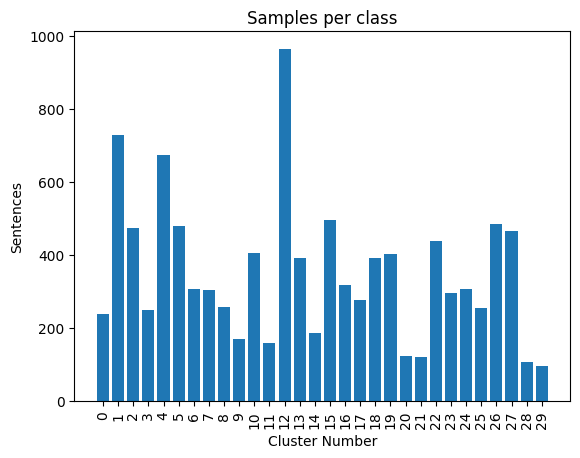

In [ ]:
k = 30
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
cluster_matrix = kmeans.fit_transform(sentences_list_embeddings)
print(cluster_matrix)
clusters = np.argmin(cluster_matrix, axis=-1)
print(clusters)

uniques, counts = np.unique(clusters, return_counts=True)
plt.bar(uniques, counts)
plt.xlabel('Cluster Number')
plt.ylabel('Sentences')
plt.xticks(uniques, rotation=90)
plt.title('Samples per class')
plt.show()

In [ ]:
top_sentence_per_cluster = []

# print the top 10 words in each cluster
for i in range(k):
    centroid = kmeans.cluster_centers_[i]    
    sorted_terms = centroid.argsort()[::-1]
    print(f"\nCluster {i}")

    i_labelled_sentence_vectors = sentences_list_embeddings[kmeans.labels_ == i]
    i_labelled_sentences = np.array(sentences_list)[kmeans.labels_ == i]
    # sorting the terms to most similar to the centroid
    sorted_sentences = i_labelled_sentences[np.argsort(cosine_similarity(i_labelled_sentence_vectors, [centroid]).flatten())[::-1]]
    top_sentence_per_cluster.append(sorted_sentences[0])

    for idx, sentence in enumerate(sorted_sentences[:10]):
        print(str(idx + 1) + ") ",sentence)


Cluster 0
1)  a boy jumps into the blue pool water.
2)  A young boy jumping in the air at the beach.
3)  A boy doing a back flip into a swimming pool.
4)  A boy jumping in the air on the beach.
5)  A boy goes down an inflatable slide.
6)  A little boy and a little girl playing together outside.
7)  A boy jumps into a not-so-crowded public pool.
8)  A little boy in denim overalls slides down an orange slide.
9)  A child is jumping into a swimming pool.
10)  A boy doing a wheelie on a plank with the beach in the background.

Cluster 1
1)  In an interview, Ms. Healey, who is a criminologist, said many lawmakers here and across the country shared a wariness toward capital punishment.
2)  In an interview, Healey, who is a criminologist, acknowledged that much of the sentiment among legislators here and across the country was wariness toward capital punishment.
3)  The differences between Grassley and Thomas on energy and Medicare have become so pointed that other members say their angry pe

In [ ]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=50, random_state=42)
pca_embeddings = pca_model.fit_transform(sentences_list_embeddings)

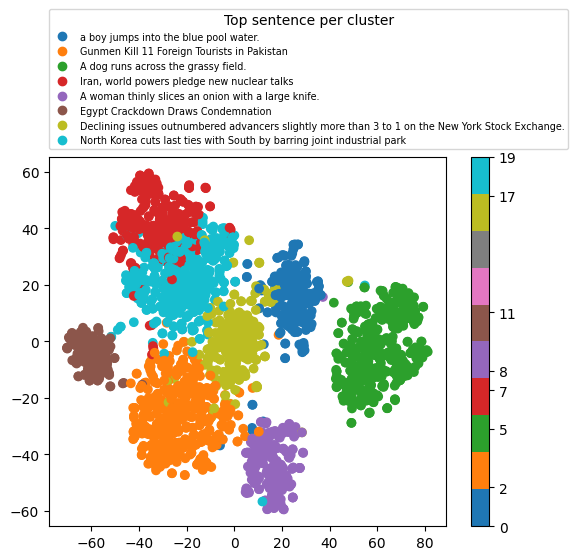

In [ ]:
# visualize selected clusters using manifold learning
from sklearn.manifold import TSNE
from matplotlib import ticker

selected_clusters = [0, 2, 5, 7, 8, 11, 17, 19]
cluster_mask = np.isin(clusters, selected_clusters)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(pca_embeddings[cluster_mask])
# plot the clusters printng the color scale
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters[cluster_mask], cmap='tab10')
handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, np.array(top_sentence_per_cluster)[selected_clusters], loc='lower left', bbox_to_anchor=(0, 1.02, 1, 0.2), ncol=1, borderaxespad=0., fontsize='x-small', title='Top sentence per cluster')
# (generate plot here)
cb = plt.colorbar()
cb.set_ticks(selected_clusters)
plt.show()


# Extensions

## Improving performance with additional data
Oftentimes we can improve performance of a model on a particular task by simply including 
additional data in the training set. 

In the first part we will include the dev set of STSb and sentences taken from the [STS 2016](https://alt.qcri.org/semeval2016/task1/index.php?id=data-and-tools) dataset.

In the second part we will use unlabelled sentences from the [simplewiki](https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/simplewiki-2020-11-01.jsonl.gz) dataset to improve unsupervised models.

### Using additional STS data

In [29]:
sts_2016_df = pd.read_csv('Dataset/sts2016-test-with-scores.csv', sep='\t', header=None, names=['filename', 'genre', 'score', 'sentence1', 'sentence2'])
sts_2016_df

,filename,genre,score,sentence1,sentence2
0,STS2016.input,plagiarism,1.0,Vector space representation results in the los...,"If a term occurs in the document, the value wi..."
1,STS2016.input,plagiarism,1.0,Inheritance in object oriented programming is ...,The peropos of inheritance in object oriented ...
2,STS2016.input,plagiarism,5.0,"To explain further vector space models, basica...",A document is represented as a vector.
3,STS2016.input,plagiarism,3.0,Bayes theorem was names after Rev Thomas Baye...,"As an official theorem, Bayes' theorem is vali..."
4,STS2016.input,plagiarism,2.0,If a term appears in the document then its val...,A document is represented as a vector and each...
...,...,...,...,...,...
678,STS2016.input,question-question,4.0,How to make good coffee in a Moka pot?,How to make more than one good cup of coffee w...
679,STS2016.input,question-question,1.0,How do I prepare this porous interior wall for...,How do I install a new interior partition wall?
680,STS2016.input,question-question,4.0,What could be causing my GFCI to trip?,What could be causing my GFCI outlet to trip?
681,STS2016.input,question-question,1.0,How do I prepare this porous interior wall for...,How do I make this paint match?


In [34]:
# append sentence1 sentence2 and score from sts_2016_df, dev_df and train_df
extended_train_df = pd.concat([train_df[['sentence1', 'sentence2', 'score']], dev_df[['sentence1', 'sentence2', 'score']], sts_2016_df[['sentence1', 'sentence2', 'score']]])
extended_train_df.reset_index(inplace=True, drop=True)
extended_train_df

,sentence1,sentence2,score
0,A plane is taking off.,An air plane is taking off.,5.00
1,A man is playing a large flute.,A man is playing a flute.,3.80
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.80
3,Three men are playing chess.,Two men are playing chess.,2.60
4,A man is playing the cello.,A man seated is playing the cello.,4.25
...,...,...,...
7927,How to make good coffee in a Moka pot?,How to make more than one good cup of coffee w...,4.00
7928,How do I prepare this porous interior wall for...,How do I install a new interior partition wall?,1.00
7929,What could be causing my GFCI to trip?,What could be causing my GFCI outlet to trip?,4.00
7930,How do I prepare this porous interior wall for...,How do I make this paint match?,1.00


In [38]:
extended_sentences_list = extended_train_df['sentence1'].tolist() + extended_train_df['sentence2'].tolist()

print(f'Number of sentences in original train set: {len(sentences_list)}')
print(f'Number of sentences in extended train set: {len(extended_sentences_list)}')

no_punct_extended_sentences_list = np.array([remove_special_chars(s) for s in extended_sentences_list])
clean_extended_sentences_list = np.array([remove_stop_words(s) for s in no_punct_extended_sentences_list])
lemmatized_extended_sentences_list = np.array([remove_stop_words(lemmatize(remove_special_chars(sentence)).lower()) for sentence in clean_sentences_list])

Number of sentences in original train set: 10566
Number of sentences in extended train set: 15864


#### TF-IDF

In [43]:
tfidf_vectorizer_extended = TfidfVectorizer(analyzer='word', ngram_range=(1,1))
tfidf_vectorizer_extended.fit(extended_sentences_list)

print("Pearson correlation TF-IDF:", evaluate_correlation(tfidf_vectorizer_extended, test_df).correlation)

trigrams_tfidf_vectorizer_extended = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5))
trigrams_tfidf_vectorizer_extended.fit(extended_sentences_list)

print("Pearson correlation TF-IDF character n-gram:", evaluate_correlation(trigrams_tfidf_vectorizer_extended, test_df).correlation)

Pearson correlation TF-IDF: 0.6756069305364506
Pearson correlation TF-IDF character n-gram: 0.7186058157124121


#### Word2Vec

In [44]:
tokenized_extended_sentences = [word_tokenize(w) for w in lemmatized_extended_sentences_list]
model = Word2Vec(tokenized_extended_sentences, vector_size=50, min_count=4, window=5, negative=10, workers=4, sg=0, cbow_mean=1, epochs=150, seed=42)

In [ ]:
%pip install -U sentence-transformers
%pip install datasets

In [27]:
from sentence_transformers import SentenceTransformer, CrossEncoder, util
from datetime import datetime

/home/fabio/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Semantic Search

One potential extension involves utilizing **transformers** to generate **embeddings** for an entire collection of sentences, which can then be used for processing various queries.

Here's a straightforward algorithm: begin by encoding the query, then calculate a pairwise score (such as **cosine similarity**) between the encoded query and each embedding vector within the sentence corpus. Finally, extract the **k nearest neighbors** based on the highest scores obtained.

In [28]:
transformer = SentenceTransformer('stsb-distilroberta-base-v2')
cross_encoder = CrossEncoder('cross-encoder/stsb-distilroberta-base', num_labels=1)

In [29]:
sentences_embeddings = transformer.encode(sentences_list, convert_to_tensor=True, show_progress_bar=True)
sentences_embeddings.shape

Batches: 100%|██████████| 331/331 [03:40<00:00,  1.50it/s]


torch.Size([10566, 768])

In [30]:
query = "Obama is eating an icecream"
embedded_query = transformer.encode(query, convert_to_tensor=True)

In [31]:
t_start = datetime.now()
results = pd.DataFrame(util.semantic_search(
    embedded_query, 
    sentences_embeddings, 
    score_function=util.cos_sim, top_k=10
)[0])
t_stop = datetime.now()
print(f"Search time: {t_stop - t_start}")

Search time: 0:00:00.018373


In [32]:
print(f"Query: \"{query}\"")
print("---------------------------------------")
for idx, row in results.iterrows():
    print(f"{idx + 1}) {row['score']:.2f} - {sentences_list[int(row['corpus_id'])]}")

Query: "Obama is eating an icecream"
---------------------------------------
1) 0.50 - Obama signs up for Obamacare
2) 0.48 - A man is eating.
3) 0.47 - A man is eating a bowl of cereal.
4) 0.46 - A woman is eating something.
5) 0.45 - A man is eating a banana.
6) 0.44 - The man is eating cereal.
7) 0.44 - Obama jokes about himself at reporters' dinner
8) 0.44 - A girl is eating a cupcake.
9) 0.44 - A man is eating his food.
10) 0.44 - Obama to sign up for Obamacare


### ReRanking

Alternatively, we can use **CrossEncoders**, a model that takes two sentences as inputs and directly predicts the matching score. By utilizing the **CrossEncoders**, we can generate an **array of scores** by iteratively passing the query with each sentence in the corpus. Then, we can extract the **top k scores**.

In [38]:
# pairing the query with the sentences
model_inputs = [[query, s] for s in sentences_list]

t_start = datetime.now()
# compute the scores
scores = cross_encoder.predict(model_inputs)
t_stop = datetime.now()
print(f"Search time: {t_stop - t_start}")

print(f"Query: \"{query}\"")
print("---------------------------------------")
for i, idx in enumerate(np.argsort(-scores)[:10]):
    print(f"{i + 1}) {scores[idx]:.2f} - {sentences_list[idx]}")

Search time: 0:06:12.657949
Query: "Obama is eating an icecream"
---------------------------------------
1) 0.51 - A man is eating.
2) 0.44 - A man is eating his food.
3) 0.41 - A person is eating at a table.
4) 0.36 - A man and woman is eating.
5) 0.29 - The man is eating cereal.
6) 0.28 - after the first meeting between leaders of the european union and leaders from albania, bosnia and herzegowina, croatia, macedonia and serbia and montenegro, leaders from the western balkan countries pledge to diminish organized crime and corruption in the balkans to meet requirements of european union membership. 
7) 0.26 - leaders from albania, bosnia and herzegowina, croatia, macedonia and serbia and montenegro met for the first time with european union leaders to pursue joining the european union.
8) 0.24 - Ha, ha, ha, ha, ha, ha!
9) 0.24 - A woman is eating something.
10) 0.24 - A man is eating a bowl of cereal.


Although this approach yields better results, it is slower. 

An enhancement to the previous algorithm would involve extracting the top k query results and subsequently **re-ranking** them using the cross encoder.

In [36]:
t_start = datetime.now()
# extract top k sentences
results = pd.DataFrame(util.semantic_search(
    embedded_query, 
    sentences_embeddings, 
    score_function=util.cos_sim, top_k=10
)[0])
# pairing the query to the top k sentences
result_sentences = [sentences_list[int(row['corpus_id'])] for idx, row in results.iterrows()]
model_inputs = [[query, s] for s in result_sentences]

# Predict similarity score
scores = cross_encoder.predict(model_inputs)

t_stop = datetime.now()
print(f"Search time: {t_stop - t_start}")

print(f"Query: \"{query}\"")
print("---------------------------------------")
for i, idx in enumerate(np.argsort(-scores)):
    print(f"{i + 1}) {scores[idx]:.2f} - {result_sentences[idx]}")

Search time: 0:00:00.227159
Query: "Obama is eating an icecream"
---------------------------------------
1) 0.51 - A man is eating.
2) 0.44 - A man is eating his food.
3) 0.29 - The man is eating cereal.
4) 0.24 - A woman is eating something.
5) 0.24 - A man is eating a bowl of cereal.
6) 0.24 - A man is eating a banana.
7) 0.23 - A girl is eating a cupcake.
8) 0.11 - Obama jokes about himself at reporters' dinner
9) 0.08 - Obama signs up for Obamacare
10) 0.07 - Obama to sign up for Obamacare
